# COMP579 Assignment 3 Q1

Value-based methods with linear function approximation

In [2]:
import gym
import math
import numpy as np
import matplotlib.pyplot as plt
import dill
dill.settings['recurse'] = True
from pathos.multiprocessing import ProcessingPool as Pool
import warnings
warnings.filterwarnings("error")
warnings.simplefilter('ignore', DeprecationWarning)

### helper functions for tile encoding


In [3]:
# creates tilings in a list of size num_bins with proper offset
# create_tilings([-12],[6],2,2) == [[-18,-6,6],[-12,0,12]]
def get_tilings(state_min, state_max, num_tilings, num_bins):
    odds_to_use = [1.0, 3.0, 5.0, 7.0]
    dimension_tiles = []
    for k in range(len(state_min)):
        tiles = []
        for i in range(num_tilings):
            tiling = []
            # not perfectly generilizable but works for both envs
            if state_max[k] == math.inf or state_min == -math.inf:
                tiling.append(-math.inf)
                new_min = -10.0 # 10 chosen cuz of post on ed, no real other reason
                new_max = 10.0 
                absolute_range = new_max - new_min        # since Length = w * #bins-1 + w/(1+(n-1) * offset_odd)   where w is width of a tile and n is number of bins/tiles   -> w = L/(#bins-1 + 1/(1 + n * offset_odd + offset_odd))
                width = absolute_range / (num_bins-3 + 1/(1 + num_tilings * odds_to_use[k] - odds_to_use[k]))
                offset =   odds_to_use[k] * (width / (1+ (num_tilings-1) * odds_to_use[k]))
                for j in range(num_bins-1):
                    interval = new_min + j * width - i * offset
                    tiling.append(interval)
                tiling.append(math.inf)
            else:    
                absolute_range = float(state_max[k]) - float(state_min[k])             # since Length = w * #bins-1 + w/(1+(n-1) * offset_odd)   where w is width of a tile and n is number of bins/tiles   -> w = L/(#bins-1 + 1/(1 + n * offset_odd + offset_odd))
                width = absolute_range / (num_bins-1 + 1/(1 + num_tilings * odds_to_use[k] - odds_to_use[k]))
                offset =   odds_to_use[k] * (width / (1+ (num_tilings-1) * odds_to_use[k]))
                for j in range(num_bins+1):
                    interval = state_min[k] + j * width - i * offset
                    tiling.append(interval)
            tiles.append(tiling)
        dimension_tiles.append(tiles)
    return dimension_tiles

# input a continuous state and a grid made from create_tilings
# outputs a np array of the vector representation of state  NOT FLATTENED YET
def continuous_state_to_vector(state, grid):
    dimension = np.zeros((len(grid),len(grid[0]),len(grid[0][0])-1))
    for i in range(len(grid)):
        for j in range(len(grid[0])):
            for k in range(len(grid[0][0]) - 1):
                if  grid[i][j][k] <= state[i] and (grid[i][j][k+1] > state[i] or (grid[i][j][k+1] == state[i] and (k+1 == len(grid[0][0]) - 1) )):
                    dimension[i][j][k] = 1
                else:
                    dimension[i][j][k] = 0
    return dimension

In [4]:
class ExpectedSarsa:
  def __init__(self, env, alpha, gamma, epsilon, tilling, bins, state_mins, state_max):
    self.env = env
    self.alpha = alpha
    self.gamma = gamma
    self.epsilon = epsilon
    self.tilling = tilling
    self.bins = bins
    state_space = bins*tilling*env.observation_space.shape[0]  
    self.w =  np.random.uniform(low=-0.001, high=0.001, size=(env.action_space.n, state_space)) # weights are a state_space by num_of_actions array    (the weights make up the table)
    self.grids = get_tilings(state_mins,state_max,tilling,bins)


  # epsilon greedy policy  
  def select_action(self, s):
    # s is the current state
    s_vector = continuous_state_to_vector(s,self.grids).flatten()

    possible_actions = np.zeros(self.env.action_space.n)
    for i in range(len(possible_actions)):
       possible_actions[i] = np.dot(self.w[i], s_vector)
    
    random_number = np.random.uniform(0, 1)
    if self.epsilon < random_number :
      # if finished training, then choose the optimal policy
      return np.argmax(possible_actions)
    else:
      return self.env.action_space.sample()

  def update(self, s, a, r, s_prime, done):
    # get the vector representation of the continuous states
    s_vector = continuous_state_to_vector(s,self.grids).flatten()
    s_prime_vector = continuous_state_to_vector(s_prime,self.grids).flatten()

    # get the q values 
    q = np.dot(self.w[a], s_vector)

    #get the possible q values from s_prime
    q_primes = np.zeros(self.env.action_space.n)
    for i in range(len(q_primes)):
       q_primes[i] = np.dot(self.w[i], s_prime_vector)
    
    #get the probability of each action using e greedy policy
    probabilities = np.zeros(self.env.action_space.n)
    best_action = np.argmax(q_primes)
    for action in range(len(q_primes)):
      if action == best_action:
        probabilities[action] = (1 - self.epsilon) + (self.epsilon / len(q_primes))
      else:
        probabilities[action] = self.epsilon / len(q_primes)
    # find the expectation
    expectation = np.dot(probabilities,q_primes)

    w_update = 0
    if not done:
      w_update = self.alpha * (r - q)
    else:
      try:
        w_update = self.alpha * (r + self.gamma * expectation - q)
      except RuntimeWarning:
        print(expectation)
        print(q)
        print(w_update)
    try:
      self.w[a] += w_update * s_vector
    except RuntimeWarning:
      print(w_update)
      print(s_vector)
      print(self.w[a])
    return
  
  # function that runs each episode
  def run_episode_ExpectedSarsa(self): 
    s = self.env.reset()[0] # Reset env and get init observation
    done = False
    total_r = 0 # Useful for the plots
    a = self.select_action(s)
    while not done:
      s_prime,r,truncated,terminated,info = self.env.step(a) # New version of gym --> 5 outputs
      done = truncated or terminated
      total_r+= r
      # Choose a_prime from s_prime using policy
      a_prime = self.select_action(s_prime)
      self.update(s, a, r, s_prime, done) 

      s = s_prime 
      a = a_prime

    return total_r
  

class QLearning:
  def __init__(self, env, alpha, gamma, epsilon, tilling, bins, state_mins, state_max):
    self.env = env
    self.alpha = alpha
    self.gamma = gamma
    self.epsilon = epsilon
    self.tilling = tilling
    self.bins = bins
    state_space = bins*tilling*env.observation_space.shape[0]  
    self.w =  np.random.uniform(low=-0.001, high=0.001, size=(env.action_space.n, state_space)) # weights are a state_space by num_of_actions array    (the weights make up the table)
    self.grids = get_tilings(state_mins,state_max,tilling,bins)


  # epsilon greedy policy  
  def select_action(self, s):
    # s is the current state
    s_vector = continuous_state_to_vector(s,self.grids).flatten()

    possible_actions = np.zeros(self.env.action_space.n)
    for i in range(len(possible_actions)):
       possible_actions[i] = np.dot(self.w[i], s_vector)
    
    random_number = np.random.uniform(0, 1)
    if self.epsilon < random_number :
      # if finished training, then choose the optimal policy
      return np.argmax(possible_actions)
    else:
      return self.env.action_space.sample()

  def update(self, s, a, r, s_prime, done):
    # get the vector representation of the continuous states
    s_vector = continuous_state_to_vector(s,self.grids).flatten()
    s_prime_vector = continuous_state_to_vector(s_prime,self.grids).flatten()

    # get the q values 
    q = np.dot(self.w[a], s_vector)

    #get the possible q values from s_prime
    q_primes = np.zeros(self.env.action_space.n)
    for i in range(len(q_primes)):
       q_primes[i] = np.dot(self.w[i], s_prime_vector)

    best_action = np.argmax(q_primes)
    # find the expectation

    w_update = 0
    if not done:
      w_update = self.alpha * (r - q)
    else:
      try:
        w_update = self.alpha * (r + self.gamma * q_primes[best_action] - q)
      except RuntimeWarning:
        print(q)
        print(w_update)
    try:
      self.w[a] += w_update * s_vector
    except RuntimeWarning:
      print(w_update)
      print(s_vector)
      print(self.w[a])
    return
  
  # function that runs each episode
  def run_episode_QLearning(self): 
    s = self.env.reset()[0] # Reset env and get init observation
    done = False
    total_r = 0 # Useful for the plots
    a = self.select_action(s)
    while not done:
      s_prime,r,truncated,terminated,info = self.env.step(a) # New version of gym --> 5 outputs
      done = truncated or terminated
      total_r+= r
      # Choose a_prime from s_prime using policy
      a_prime = self.select_action(s_prime)
      self.update(s, a, r, s_prime, done) 

      s = s_prime 
      a = a_prime

    return total_r

In [5]:
env_name_mountain = 'MountainCar-v0'
env_mountain = gym.make(env_name_mountain, max_episode_steps=500)

env_name_cart = 'CartPole-v1'
env_cart = gym.make(env_name_cart)


In [6]:
# function that runs each hyperparameter setting 
def run_experiments(env, discount_rate, lrs,epsilons, tilling, bins, state_min, state_max, num_runs=50, num_episodes=1000):
  # returns a tuple of: list of mean return for the learning curves, corresp. sd, max and min of each experiment
  # 9 x 
  performance_by_configuration = []

  for epsilon in epsilons:

    for lr in lrs: # Loop through each experiment
      performance_of_config = []

      for trial in range(num_runs):
        # Instantiate sarsa_obj based on hyperparamters
        sarsa_obj = ExpectedSarsa(env, lr/tilling, discount_rate, epsilon, tilling, bins, state_min, state_max)

        performance_by_trial_over_episode = []

        for episode in range(num_episodes):

          ep_return = sarsa_obj.run_episode_ExpectedSarsa()
          performance_by_trial_over_episode.append(ep_return)

        performance_of_config.append(performance_by_trial_over_episode)

      performance_by_configuration.append(performance_of_config)

  return performance_by_configuration

def run_trial_Sarsa(env, discount_rate, lr, epsilon, tilling, bins, state_min, state_max, num_episodes):
  sarsa_obj = ExpectedSarsa(env, lr/tilling, discount_rate, epsilon, tilling, bins, state_min, state_max)
  performance_by_trial = []
  for episode in range(num_episodes):
    ep_return = sarsa_obj.run_episode_ExpectedSarsa()
    performance_by_trial.append(ep_return)
  return performance_by_trial

def run_trial_Q_Learning(env, discount_rate, lr, epsilon, tilling, bins, state_min, state_max, num_episodes):
  sarsa_obj = QLearning(env, lr/tilling, discount_rate, epsilon, tilling, bins, state_min, state_max)
  performance_by_trial = []
  for episode in range(num_episodes):
    ep_return = sarsa_obj.run_episode_QLearning()
    performance_by_trial.append(ep_return)
  return performance_by_trial

# multiprocessing
def worker_sarsa(args):
    try:
        return run_trial_Sarsa(*args)
    except Exception as e:
        return str(e)

# multiprocessing
def worker_q_learning(args):
    try:
        return run_trial_Q_Learning(*args)
    except Exception as e:
        return str(e)

# function that runs each hyperparameter setting 
def run_experiments_threaded(env, discount_rate, lrs, epsilons, tilling, bins, state_min, state_max, worker, num_runs=50, num_episodes=1000):
  # returns a tuple of: list of mean return for the learning curves, corresp. sd, max and min of each experiment
  # 9 x 
  performance_by_configuration = []

  for epsilon in epsilons:

    for lr in lrs: # Loop through each experiment
      performance_of_config = []
      args = [(env, discount_rate, lr, epsilon, tilling, bins, state_min, state_max, num_episodes) for i in range(num_runs)]
      if __name__ == '__main__':
      # Use pathos.multiprocessing to run the workers
        with Pool() as p:
          results = p.amap(worker, args)
        while not results.ready():
          a = 0
        performance_of_config = results.get()
  
      performance_by_configuration.append(performance_of_config)

  return performance_by_configuration

In [31]:
gamma = 1 # Since epsiodic tasks
tillings = 10
bins = 10
lrs = [1/4, 1/8, 1/16] 
#lrs = (np.asarray(lrs) /(tillings * 10)).tolist()   # as recommended by the textbook
epsilons = [0.01, 0.1, 0.2]
num_episodes = 1000
num_runs = 6
mountain_min = [-1.2,-0.07]
mountain_max = [0.6,0.007]

cart_min = [-4.8, -math.inf, -0.418, -math.inf]
cart_max = [4.8, math.inf, 0.418, math.inf]






In [24]:
cart_pole_sarsa = run_experiments_threaded(env_cart, gamma, lrs,epsilons, tillings, bins,cart_min,cart_max, worker_sarsa, num_episodes=num_episodes, num_runs= num_runs)


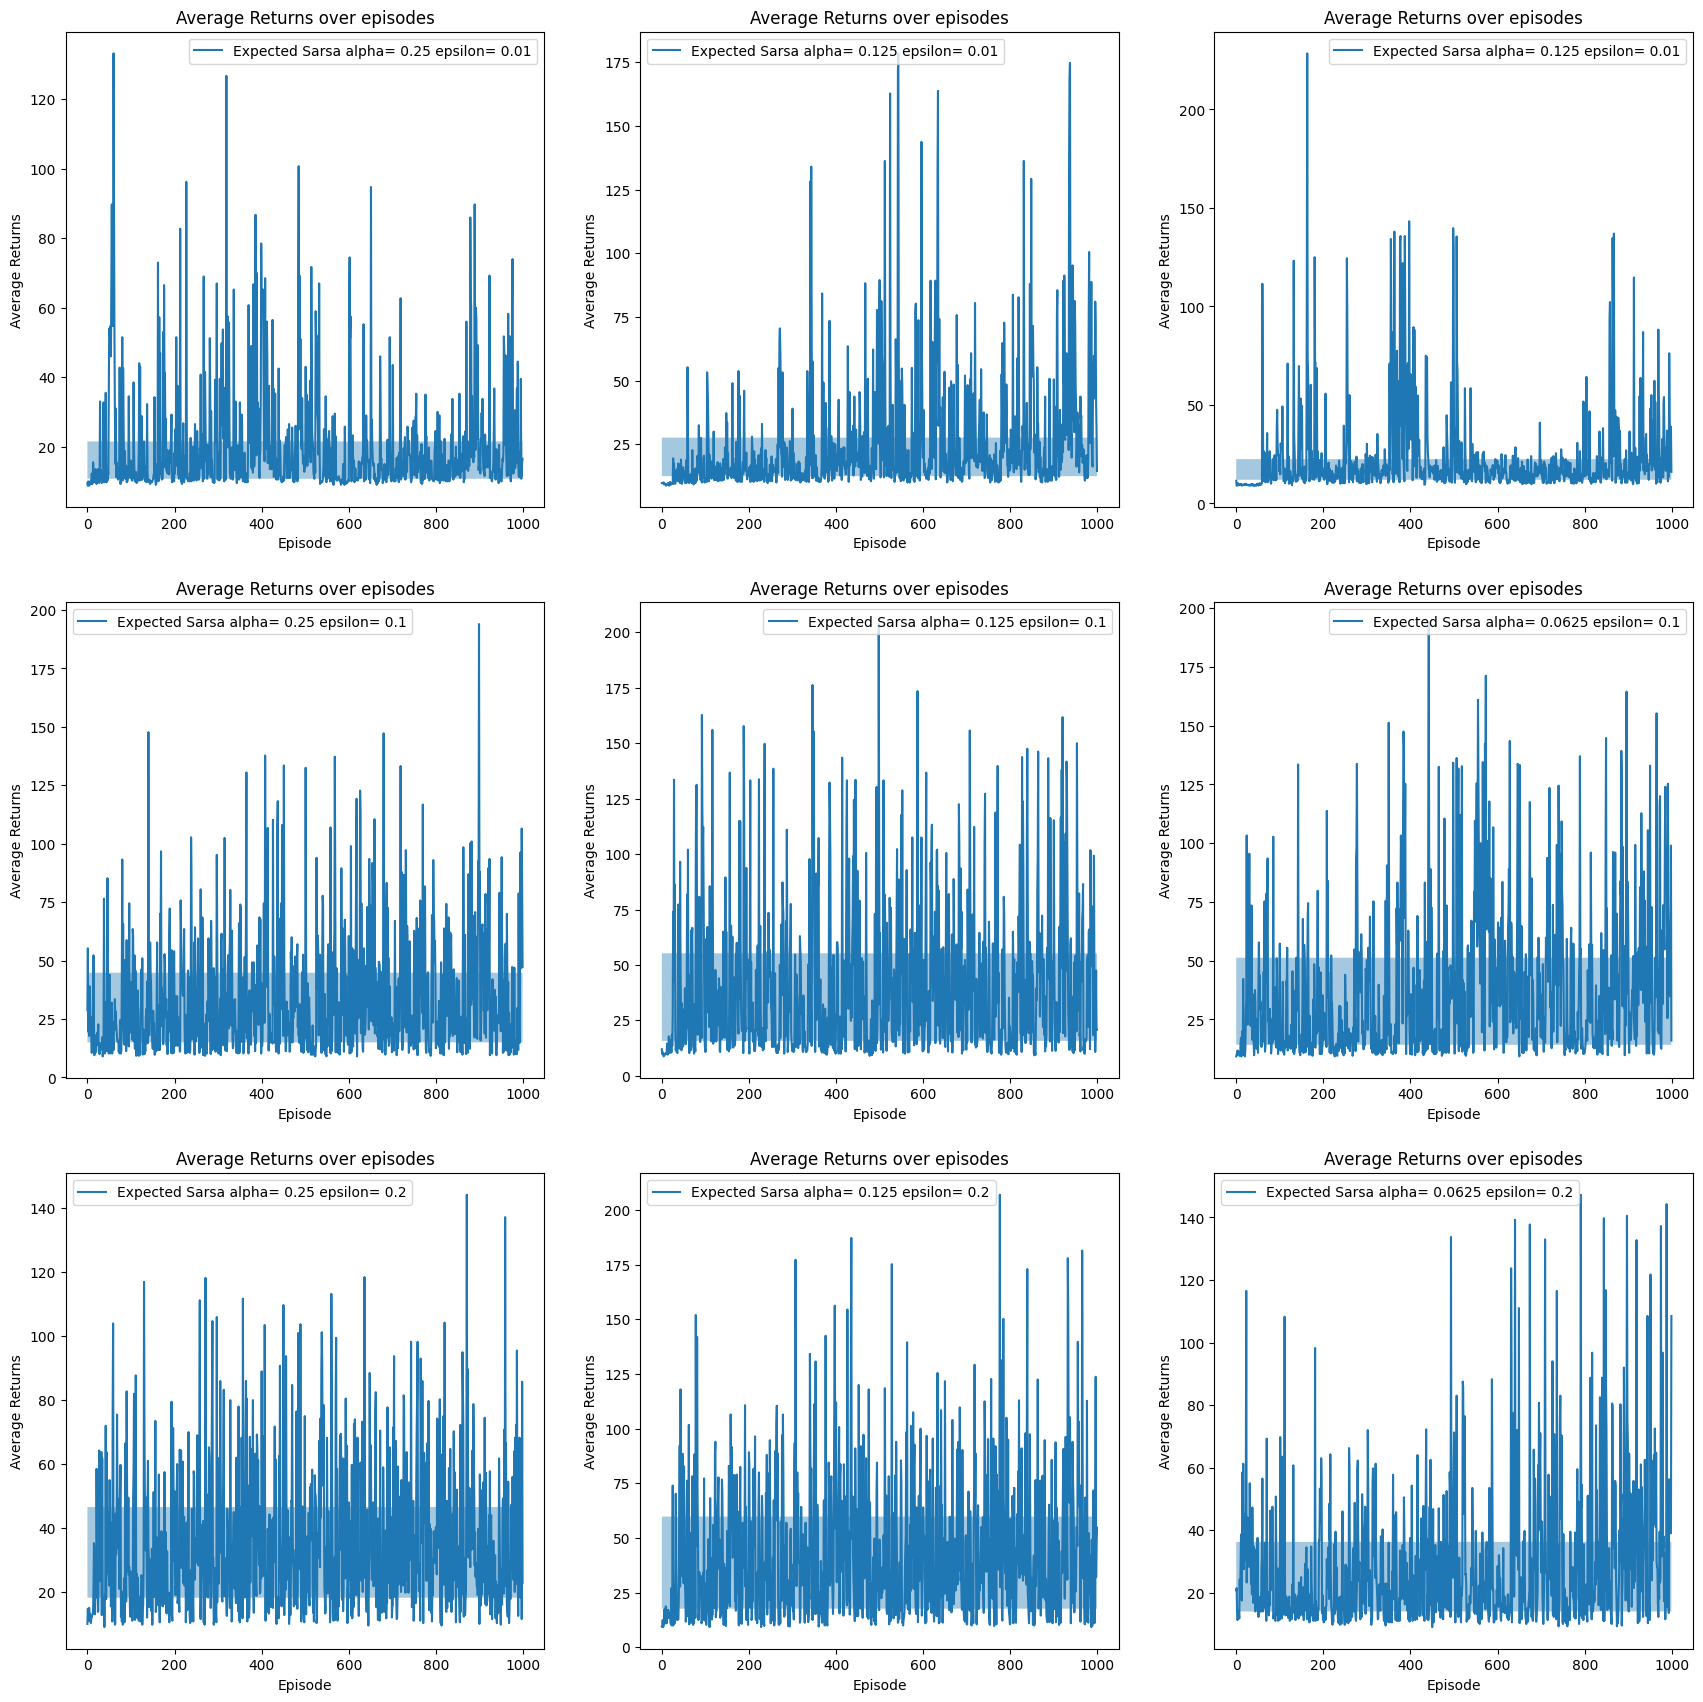

In [25]:
returns_over_configuration = []
min_over_configuration = []
max_over_configuration = []

for i in range(len(cart_pole_sarsa)):
    mean_return_over_all_trials_per_episode = []
    for j in range(num_episodes):
        mean_return_of_episode = 0
        for k in range(num_runs):
            mean_return_of_episode += cart_pole_sarsa[i][k][j]
        mean_return_of_episode = mean_return_of_episode / num_runs
        mean_return_over_all_trials_per_episode.append(mean_return_of_episode)

    q1 ,q3 = np.percentile(np.asarray(mean_return_over_all_trials_per_episode), [75 ,25])
    min_over_configuration.append(q1)
    max_over_configuration.append(q3)
    returns_over_configuration.append(mean_return_over_all_trials_per_episode)


fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(21, 21))


ax[0][0].plot(np.arange(0,num_episodes), np.asarray(returns_over_configuration[0]), label = "Expected Sarsa alpha= %s epsilon= %s" %(lrs[0], epsilons[0]))
ax[0][0].legend()
ax[0][0].set_xlabel("Episode")
ax[0][0].set_ylabel("Average Returns")
ax[0][0].set_title("Average Returns over episodes")
ax[0][0].fill_between(np.arange(0,num_episodes), min_over_configuration[0], max_over_configuration[0], alpha=0.4)
ax[0][1].plot(np.arange(0,num_episodes), np.asarray(returns_over_configuration[1]), label = "Expected Sarsa alpha= %s epsilon= %s" %(lrs[1], epsilons[0]))
ax[0][1].legend()
ax[0][1].set_xlabel("Episode")
ax[0][1].set_ylabel("Average Returns")
ax[0][1].set_title("Average Returns over episodes")
ax[0][1].fill_between(np.arange(0,num_episodes), min_over_configuration[1], max_over_configuration[1], alpha=0.4)
ax[0][2].plot(np.arange(0,num_episodes), np.asarray(returns_over_configuration[2]), label = "Expected Sarsa alpha= %s epsilon= %s" %(lrs[1], epsilons[0]))
ax[0][2].legend()
ax[0][2].set_xlabel("Episode")
ax[0][2].set_ylabel("Average Returns")
ax[0][2].set_title("Average Returns over episodes")
ax[0][2].fill_between(np.arange(0,num_episodes), min_over_configuration[2], max_over_configuration[2], alpha=0.4)
ax[1][0].plot(np.arange(0,num_episodes), np.asarray(returns_over_configuration[3]), label = "Expected Sarsa alpha= %s epsilon= %s" %(lrs[0], epsilons[1]))
ax[1][0].legend()
ax[1][0].set_xlabel("Episode")
ax[1][0].set_ylabel("Average Returns")
ax[1][0].set_title("Average Returns over episodes")
ax[1][0].fill_between(np.arange(0,num_episodes), min_over_configuration[3], max_over_configuration[3], alpha=0.4)
ax[1][1].plot(np.arange(0,num_episodes), np.asarray(returns_over_configuration[4]), label = "Expected Sarsa alpha= %s epsilon= %s" %(lrs[1], epsilons[1]))
ax[1][1].legend()
ax[1][1].set_xlabel("Episode")
ax[1][1].set_ylabel("Average Returns")
ax[1][1].set_title("Average Returns over episodes")
ax[1][1].fill_between(np.arange(0,num_episodes), min_over_configuration[4], max_over_configuration[4], alpha=0.4)
ax[1][2].plot(np.arange(0,num_episodes), np.asarray(returns_over_configuration[5]), label = "Expected Sarsa alpha= %s epsilon= %s" %(lrs[2], epsilons[1]))
ax[1][2].legend()
ax[1][2].set_xlabel("Episode")
ax[1][2].set_ylabel("Average Returns")
ax[1][2].set_title("Average Returns over episodes")
ax[1][2].fill_between(np.arange(0,num_episodes), min_over_configuration[5], max_over_configuration[5], alpha=0.4)
ax[2][0].plot(np.arange(0,num_episodes), np.asarray(returns_over_configuration[6]), label = "Expected Sarsa alpha= %s epsilon= %s" %(lrs[0], epsilons[2]))
ax[2][0].legend()
ax[2][0].set_xlabel("Episode")
ax[2][0].set_ylabel("Average Returns")
ax[2][0].set_title("Average Returns over episodes")
ax[2][0].fill_between(np.arange(0,num_episodes), min_over_configuration[6], max_over_configuration[6], alpha=0.4)
ax[2][1].plot(np.arange(0,num_episodes), np.asarray(returns_over_configuration[7]), label = "Expected Sarsa alpha= %s epsilon= %s" %(lrs[1], epsilons[2]))
ax[2][1].legend()
ax[2][1].set_xlabel("Episode")
ax[2][1].set_ylabel("Average Returns")
ax[2][1].set_title("Average Returns over episodes")
ax[2][1].fill_between(np.arange(0,num_episodes), min_over_configuration[7], max_over_configuration[7], alpha=0.4)
ax[2][2].plot(np.arange(0,num_episodes), np.asarray(returns_over_configuration[8]), label = "Expected Sarsa alpha= %s epsilon= %s" %(lrs[2], epsilons[2]))
ax[2][2].legend()
ax[2][2].set_xlabel("Episode")
ax[2][2].set_ylabel("Average Returns")
ax[2][2].set_title("Average Returns over episodes")
ax[2][2].fill_between(np.arange(0,num_episodes), min_over_configuration[8], max_over_configuration[8], alpha=0.4)

In [27]:
cart_pole_q_learning = run_experiments_threaded(env_cart, gamma, lrs,epsilons, tillings, bins,cart_min,cart_max, worker_q_learning, num_episodes=num_episodes, num_runs=num_runs)

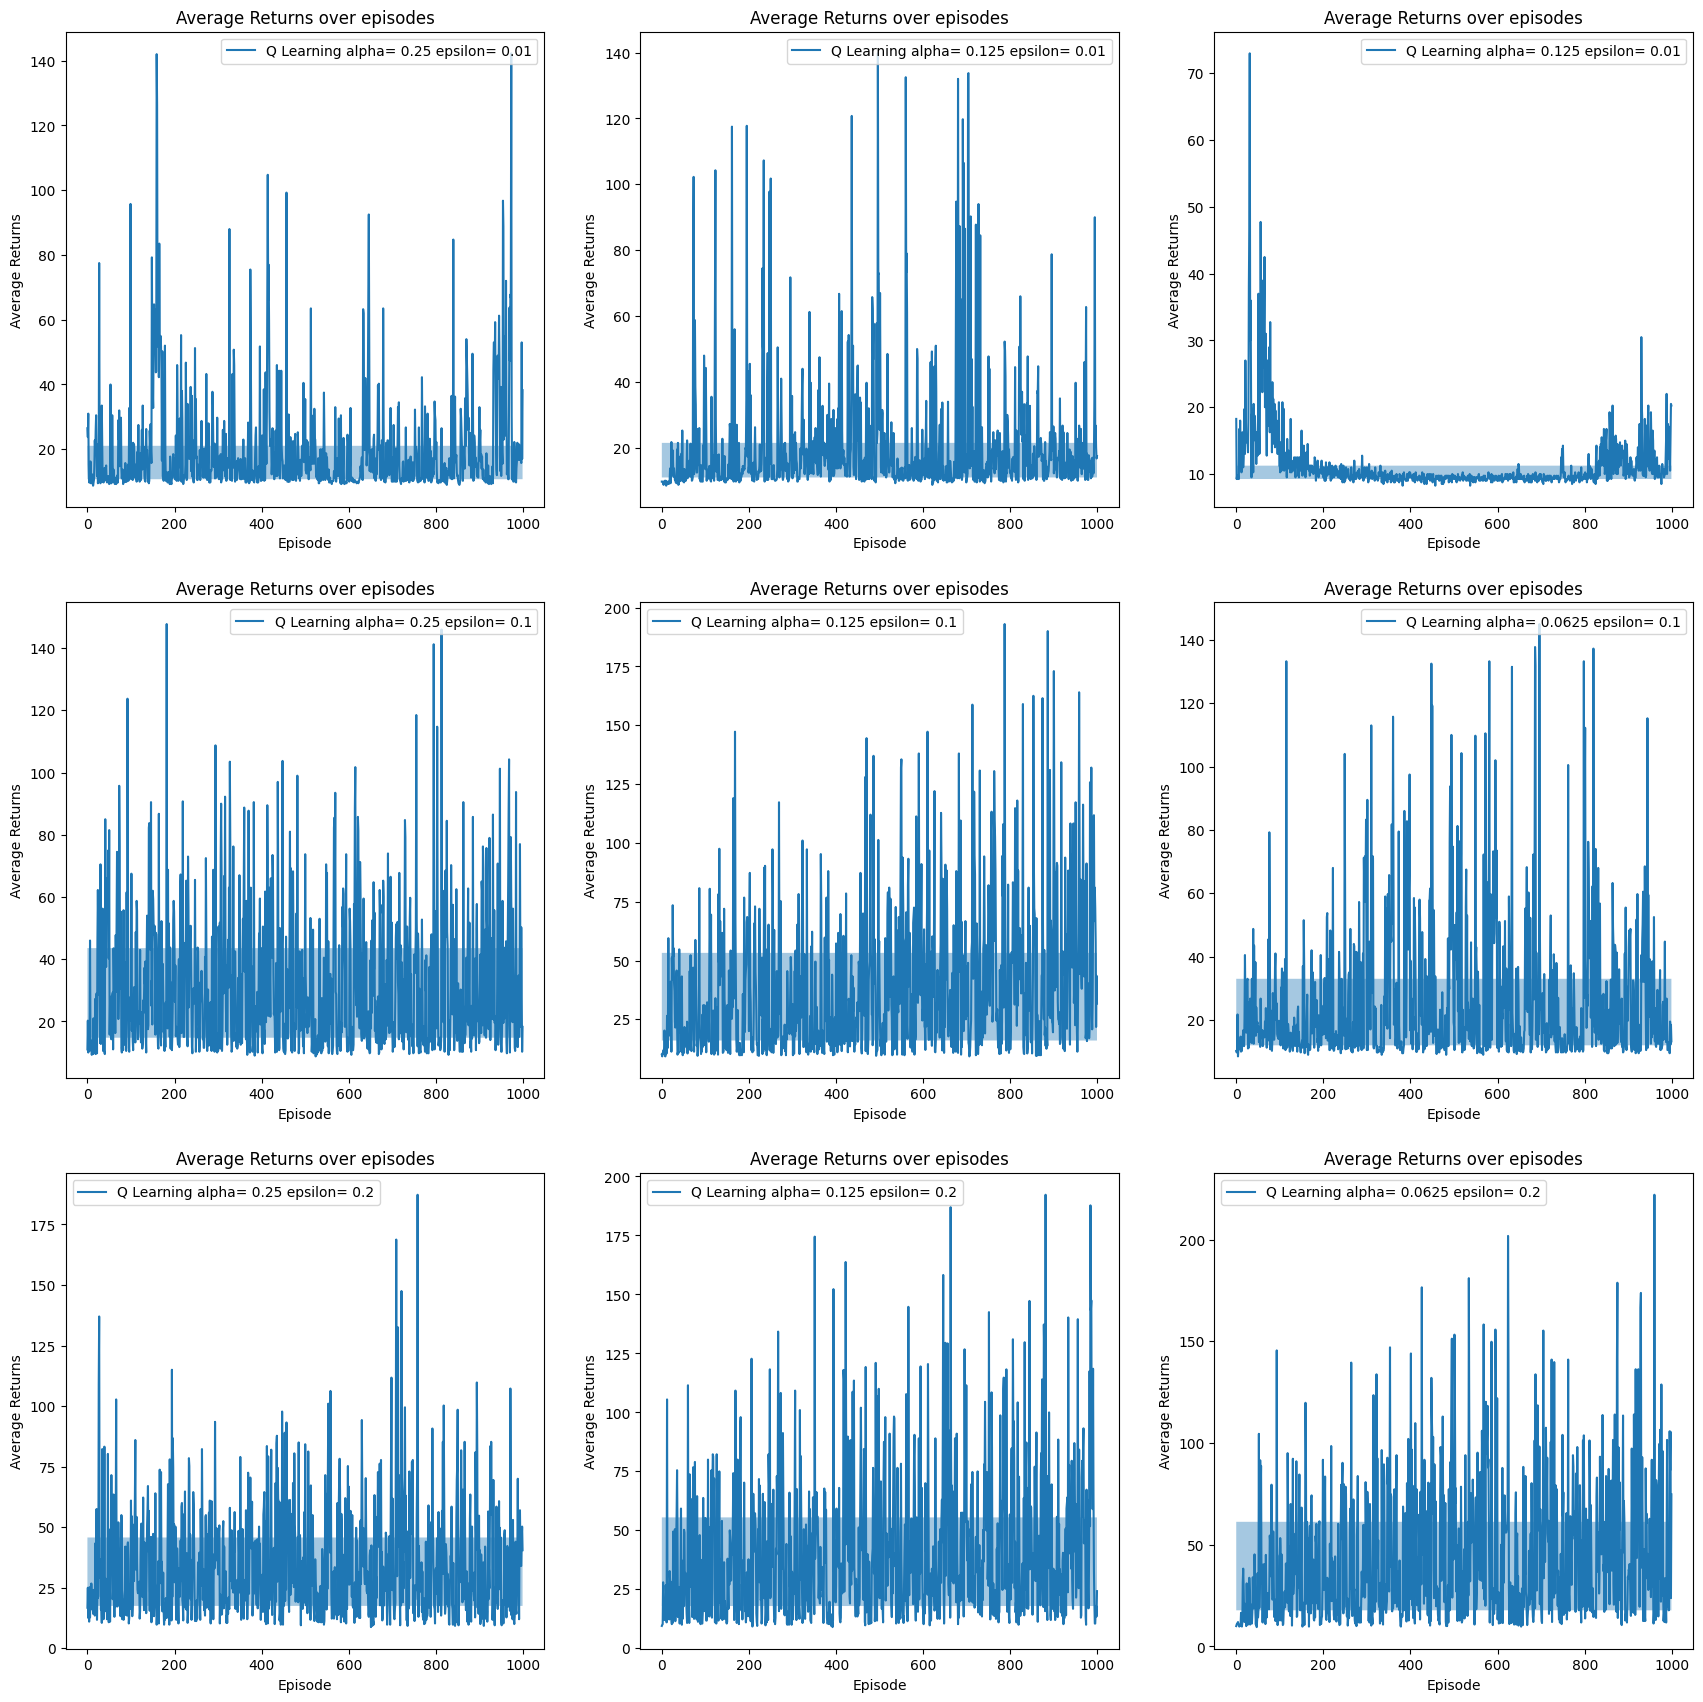

In [28]:
returns_over_configuration = []
min_over_configuration = []
max_over_configuration = []

for i in range(len(cart_pole_q_learning)):
    mean_return_over_all_trials_per_episode = []
    for j in range(num_episodes):
        mean_return_of_episode = 0
        for k in range(num_runs):
            mean_return_of_episode += cart_pole_q_learning[i][k][j]
        mean_return_of_episode = mean_return_of_episode / num_runs
        mean_return_over_all_trials_per_episode.append(mean_return_of_episode)

    q1 ,q3 = np.percentile(np.asarray(mean_return_over_all_trials_per_episode), [75 ,25])
    min_over_configuration.append(q1)
    max_over_configuration.append(q3)
    returns_over_configuration.append(mean_return_over_all_trials_per_episode)


fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(21, 21))


ax[0][0].plot(np.arange(0,num_episodes), np.asarray(returns_over_configuration[0]), label = "Q Learning alpha= %s epsilon= %s" %(lrs[0], epsilons[0]))
ax[0][0].legend()
ax[0][0].set_xlabel("Episode")
ax[0][0].set_ylabel("Average Returns")
ax[0][0].set_title("Average Returns over episodes")
ax[0][0].fill_between(np.arange(0,num_episodes), min_over_configuration[0], max_over_configuration[0], alpha=0.4)
ax[0][1].plot(np.arange(0,num_episodes), np.asarray(returns_over_configuration[1]), label = "Q Learning alpha= %s epsilon= %s" %(lrs[1], epsilons[0]))
ax[0][1].legend()
ax[0][1].set_xlabel("Episode")
ax[0][1].set_ylabel("Average Returns")
ax[0][1].set_title("Average Returns over episodes")
ax[0][1].fill_between(np.arange(0,num_episodes), min_over_configuration[1], max_over_configuration[1], alpha=0.4)
ax[0][2].plot(np.arange(0,num_episodes), np.asarray(returns_over_configuration[2]), label = "Q Learning alpha= %s epsilon= %s" %(lrs[1], epsilons[0]))
ax[0][2].legend()
ax[0][2].set_xlabel("Episode")
ax[0][2].set_ylabel("Average Returns")
ax[0][2].set_title("Average Returns over episodes")
ax[0][2].fill_between(np.arange(0,num_episodes), min_over_configuration[2], max_over_configuration[2], alpha=0.4)
ax[1][0].plot(np.arange(0,num_episodes), np.asarray(returns_over_configuration[3]), label = "Q Learning alpha= %s epsilon= %s" %(lrs[0], epsilons[1]))
ax[1][0].legend()
ax[1][0].set_xlabel("Episode")
ax[1][0].set_ylabel("Average Returns")
ax[1][0].set_title("Average Returns over episodes")
ax[1][0].fill_between(np.arange(0,num_episodes), min_over_configuration[3], max_over_configuration[3], alpha=0.4)
ax[1][1].plot(np.arange(0,num_episodes), np.asarray(returns_over_configuration[4]), label = "Q Learning alpha= %s epsilon= %s" %(lrs[1], epsilons[1]))
ax[1][1].legend()
ax[1][1].set_xlabel("Episode")
ax[1][1].set_ylabel("Average Returns")
ax[1][1].set_title("Average Returns over episodes")
ax[1][1].fill_between(np.arange(0,num_episodes), min_over_configuration[4], max_over_configuration[4], alpha=0.4)
ax[1][2].plot(np.arange(0,num_episodes), np.asarray(returns_over_configuration[5]), label = "Q Learning alpha= %s epsilon= %s" %(lrs[2], epsilons[1]))
ax[1][2].legend()
ax[1][2].set_xlabel("Episode")
ax[1][2].set_ylabel("Average Returns")
ax[1][2].set_title("Average Returns over episodes")
ax[1][2].fill_between(np.arange(0,num_episodes), min_over_configuration[5], max_over_configuration[5], alpha=0.4)
ax[2][0].plot(np.arange(0,num_episodes), np.asarray(returns_over_configuration[6]), label = "Q Learning alpha= %s epsilon= %s" %(lrs[0], epsilons[2]))
ax[2][0].legend()
ax[2][0].set_xlabel("Episode")
ax[2][0].set_ylabel("Average Returns")
ax[2][0].set_title("Average Returns over episodes")
ax[2][0].fill_between(np.arange(0,num_episodes), min_over_configuration[6], max_over_configuration[6], alpha=0.4)
ax[2][1].plot(np.arange(0,num_episodes), np.asarray(returns_over_configuration[7]), label = "Q Learning alpha= %s epsilon= %s" %(lrs[1], epsilons[2]))
ax[2][1].legend()
ax[2][1].set_xlabel("Episode")
ax[2][1].set_ylabel("Average Returns")
ax[2][1].set_title("Average Returns over episodes")
ax[2][1].fill_between(np.arange(0,num_episodes), min_over_configuration[7], max_over_configuration[7], alpha=0.4)
ax[2][2].plot(np.arange(0,num_episodes), np.asarray(returns_over_configuration[8]), label = "Q Learning alpha= %s epsilon= %s" %(lrs[2], epsilons[2]))
ax[2][2].legend()
ax[2][2].set_xlabel("Episode")
ax[2][2].set_ylabel("Average Returns")
ax[2][2].set_title("Average Returns over episodes")
ax[2][2].fill_between(np.arange(0,num_episodes), min_over_configuration[8], max_over_configuration[8], alpha=0.4)

In [32]:
mountain_car_sarsa = run_experiments_threaded(env_mountain, gamma, lrs,epsilons, tillings, bins,mountain_min,mountain_max, worker_sarsa, num_episodes=num_episodes, num_runs= num_runs)

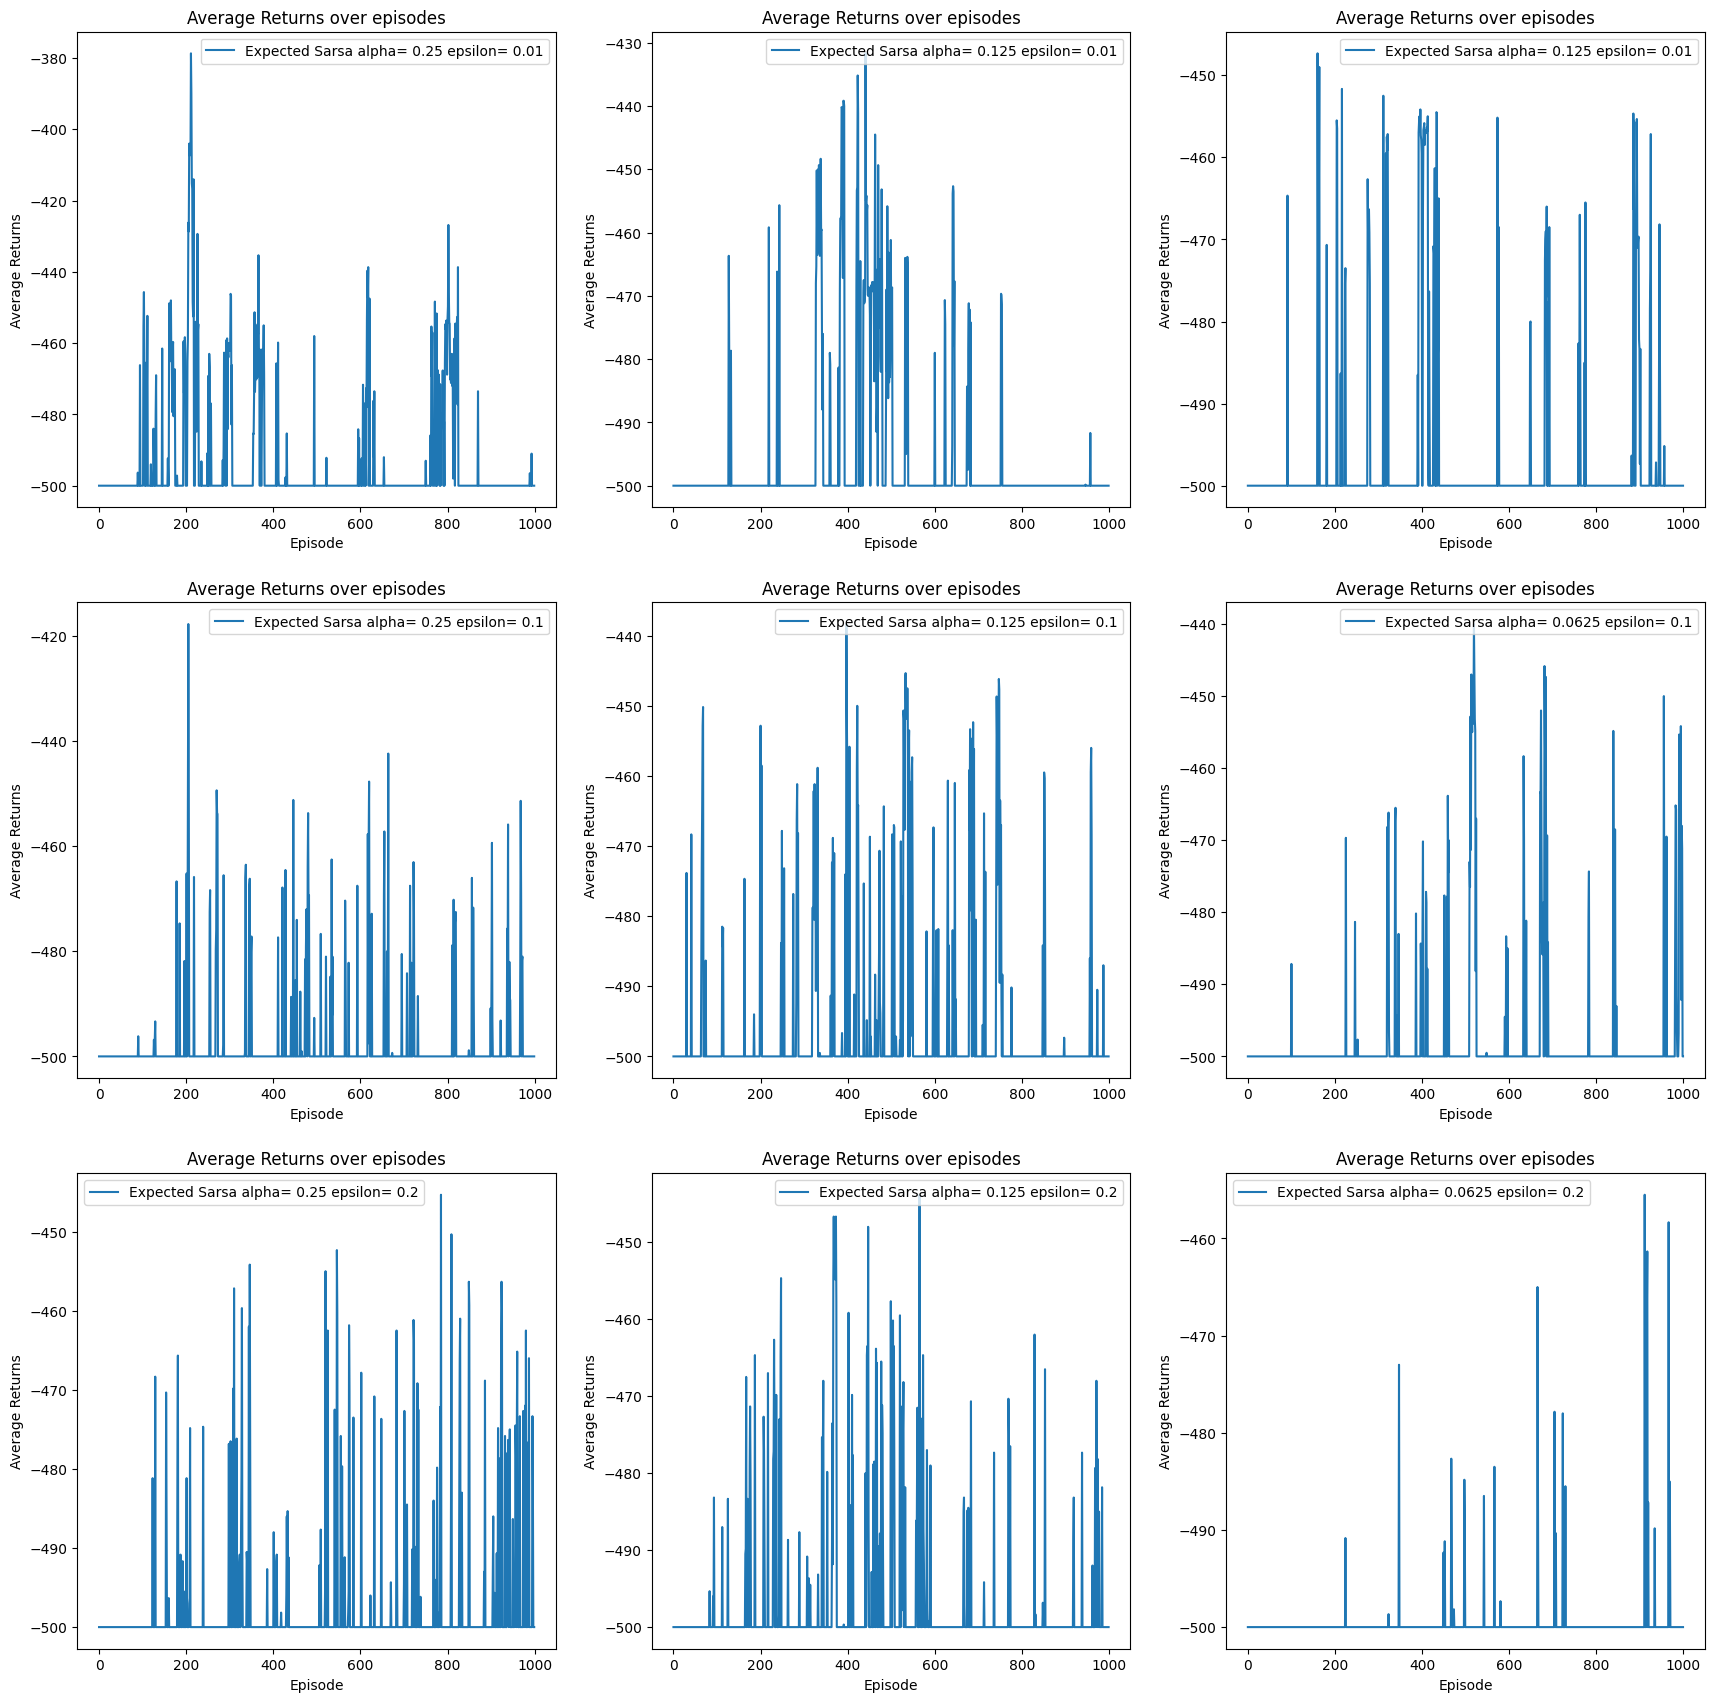

In [33]:
returns_over_configuration = []
min_over_configuration = []
max_over_configuration = []

for i in range(len(mountain_car_sarsa)):
    mean_return_over_all_trials_per_episode = []
    for j in range(num_episodes):
        mean_return_of_episode = 0
        for k in range(num_runs):
            mean_return_of_episode += mountain_car_sarsa[i][k][j]
        mean_return_of_episode = mean_return_of_episode / num_runs
        mean_return_over_all_trials_per_episode.append(mean_return_of_episode)

    q1 ,q3 = np.percentile(np.asarray(mean_return_over_all_trials_per_episode), [75 ,25])
    min_over_configuration.append(q1)
    max_over_configuration.append(q3)
    returns_over_configuration.append(mean_return_over_all_trials_per_episode)


fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(21, 21))


ax[0][0].plot(np.arange(0,num_episodes), np.asarray(returns_over_configuration[0]), label = "Expected Sarsa alpha= %s epsilon= %s" %(lrs[0], epsilons[0]))
ax[0][0].legend()
ax[0][0].set_xlabel("Episode")
ax[0][0].set_ylabel("Average Returns")
ax[0][0].set_title("Average Returns over episodes")
ax[0][0].fill_between(np.arange(0,num_episodes), min_over_configuration[0], max_over_configuration[0], alpha=0.4)
ax[0][1].plot(np.arange(0,num_episodes), np.asarray(returns_over_configuration[1]), label = "Expected Sarsa alpha= %s epsilon= %s" %(lrs[1], epsilons[0]))
ax[0][1].legend()
ax[0][1].set_xlabel("Episode")
ax[0][1].set_ylabel("Average Returns")
ax[0][1].set_title("Average Returns over episodes")
ax[0][1].fill_between(np.arange(0,num_episodes), min_over_configuration[1], max_over_configuration[1], alpha=0.4)
ax[0][2].plot(np.arange(0,num_episodes), np.asarray(returns_over_configuration[2]), label = "Expected Sarsa alpha= %s epsilon= %s" %(lrs[1], epsilons[0]))
ax[0][2].legend()
ax[0][2].set_xlabel("Episode")
ax[0][2].set_ylabel("Average Returns")
ax[0][2].set_title("Average Returns over episodes")
ax[0][2].fill_between(np.arange(0,num_episodes), min_over_configuration[2], max_over_configuration[2], alpha=0.4)
ax[1][0].plot(np.arange(0,num_episodes), np.asarray(returns_over_configuration[3]), label = "Expected Sarsa alpha= %s epsilon= %s" %(lrs[0], epsilons[1]))
ax[1][0].legend()
ax[1][0].set_xlabel("Episode")
ax[1][0].set_ylabel("Average Returns")
ax[1][0].set_title("Average Returns over episodes")
ax[1][0].fill_between(np.arange(0,num_episodes), min_over_configuration[3], max_over_configuration[3], alpha=0.4)
ax[1][1].plot(np.arange(0,num_episodes), np.asarray(returns_over_configuration[4]), label = "Expected Sarsa alpha= %s epsilon= %s" %(lrs[1], epsilons[1]))
ax[1][1].legend()
ax[1][1].set_xlabel("Episode")
ax[1][1].set_ylabel("Average Returns")
ax[1][1].set_title("Average Returns over episodes")
ax[1][1].fill_between(np.arange(0,num_episodes), min_over_configuration[4], max_over_configuration[4], alpha=0.4)
ax[1][2].plot(np.arange(0,num_episodes), np.asarray(returns_over_configuration[5]), label = "Expected Sarsa alpha= %s epsilon= %s" %(lrs[2], epsilons[1]))
ax[1][2].legend()
ax[1][2].set_xlabel("Episode")
ax[1][2].set_ylabel("Average Returns")
ax[1][2].set_title("Average Returns over episodes")
ax[1][2].fill_between(np.arange(0,num_episodes), min_over_configuration[5], max_over_configuration[5], alpha=0.4)
ax[2][0].plot(np.arange(0,num_episodes), np.asarray(returns_over_configuration[6]), label = "Expected Sarsa alpha= %s epsilon= %s" %(lrs[0], epsilons[2]))
ax[2][0].legend()
ax[2][0].set_xlabel("Episode")
ax[2][0].set_ylabel("Average Returns")
ax[2][0].set_title("Average Returns over episodes")
ax[2][0].fill_between(np.arange(0,num_episodes), min_over_configuration[6], max_over_configuration[6], alpha=0.4)
ax[2][1].plot(np.arange(0,num_episodes), np.asarray(returns_over_configuration[7]), label = "Expected Sarsa alpha= %s epsilon= %s" %(lrs[1], epsilons[2]))
ax[2][1].legend()
ax[2][1].set_xlabel("Episode")
ax[2][1].set_ylabel("Average Returns")
ax[2][1].set_title("Average Returns over episodes")
ax[2][1].fill_between(np.arange(0,num_episodes), min_over_configuration[7], max_over_configuration[7], alpha=0.4)
ax[2][2].plot(np.arange(0,num_episodes), np.asarray(returns_over_configuration[8]), label = "Expected Sarsa alpha= %s epsilon= %s" %(lrs[2], epsilons[2]))
ax[2][2].legend()
ax[2][2].set_xlabel("Episode")
ax[2][2].set_ylabel("Average Returns")
ax[2][2].set_title("Average Returns over episodes")
ax[2][2].fill_between(np.arange(0,num_episodes), min_over_configuration[8], max_over_configuration[8], alpha=0.4)

In [34]:
mountain_car_q_learning = run_experiments_threaded(env_mountain, gamma, lrs,epsilons, tillings, bins,mountain_min,mountain_max, worker_q_learning, num_episodes=num_episodes, num_runs=num_runs)

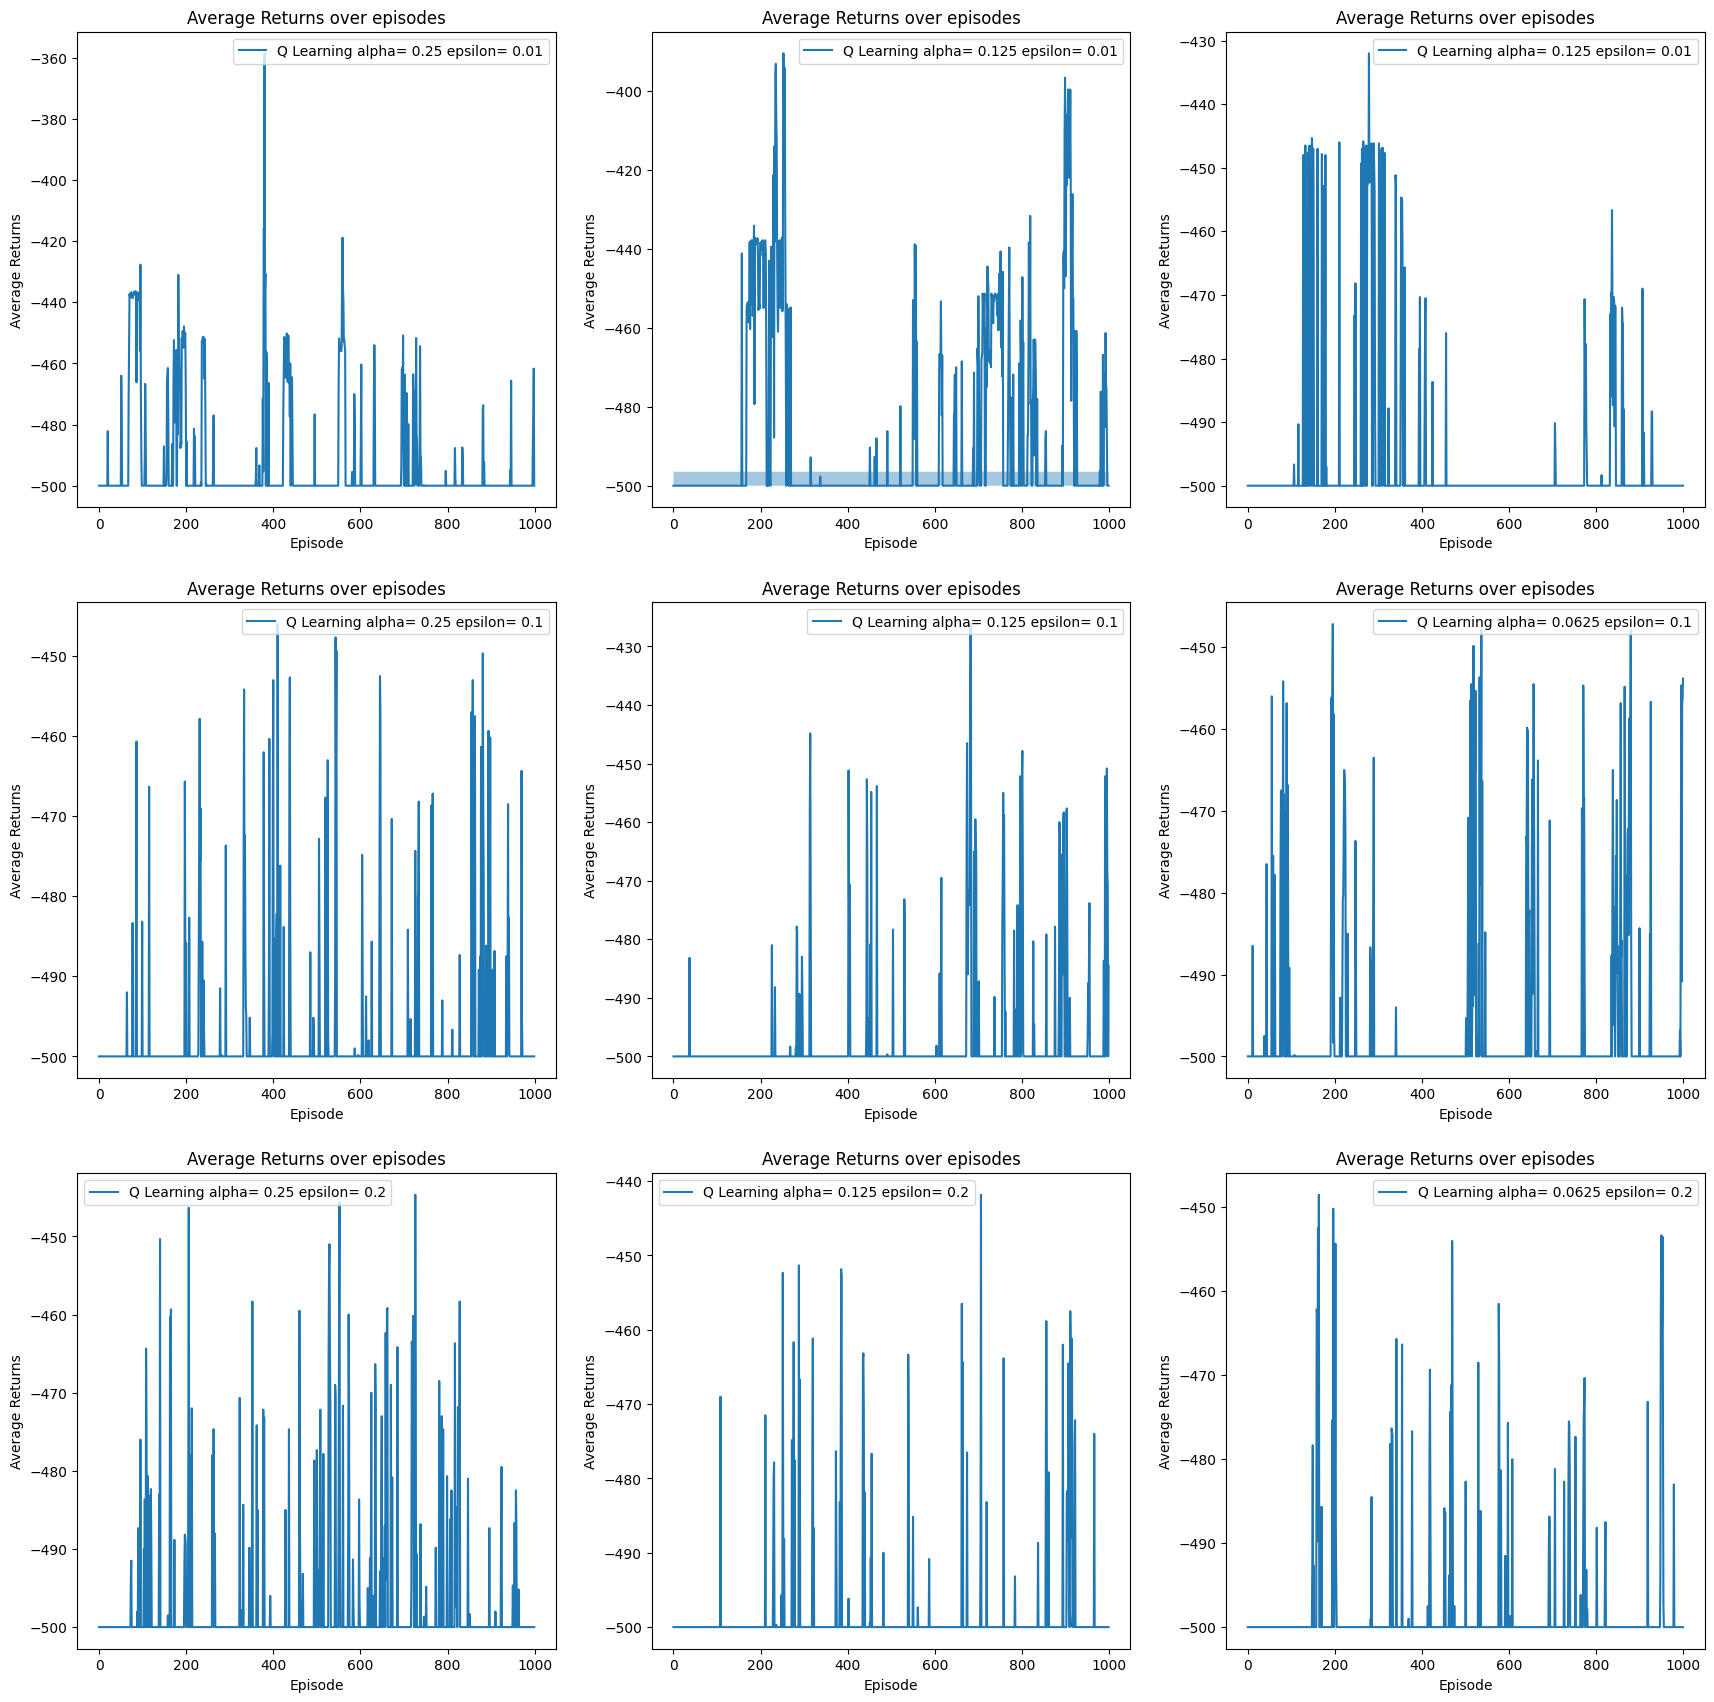

In [35]:
returns_over_configuration = []
min_over_configuration = []
max_over_configuration = []

for i in range(len(mountain_car_q_learning)):
    mean_return_over_all_trials_per_episode = []
    for j in range(num_episodes):
        mean_return_of_episode = 0
        for k in range(num_runs):
            mean_return_of_episode += mountain_car_q_learning[i][k][j]
        mean_return_of_episode = mean_return_of_episode / num_runs
        mean_return_over_all_trials_per_episode.append(mean_return_of_episode)

    q1 ,q3 = np.percentile(np.asarray(mean_return_over_all_trials_per_episode), [75 ,25])
    min_over_configuration.append(q1)
    max_over_configuration.append(q3)
    returns_over_configuration.append(mean_return_over_all_trials_per_episode)


fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(21, 21))


ax[0][0].plot(np.arange(0,num_episodes), np.asarray(returns_over_configuration[0]), label = "Q Learning alpha= %s epsilon= %s" %(lrs[0], epsilons[0]))
ax[0][0].legend()
ax[0][0].set_xlabel("Episode")
ax[0][0].set_ylabel("Average Returns")
ax[0][0].set_title("Average Returns over episodes")
ax[0][0].fill_between(np.arange(0,num_episodes), min_over_configuration[0], max_over_configuration[0], alpha=0.4)
ax[0][1].plot(np.arange(0,num_episodes), np.asarray(returns_over_configuration[1]), label = "Q Learning alpha= %s epsilon= %s" %(lrs[1], epsilons[0]))
ax[0][1].legend()
ax[0][1].set_xlabel("Episode")
ax[0][1].set_ylabel("Average Returns")
ax[0][1].set_title("Average Returns over episodes")
ax[0][1].fill_between(np.arange(0,num_episodes), min_over_configuration[1], max_over_configuration[1], alpha=0.4)
ax[0][2].plot(np.arange(0,num_episodes), np.asarray(returns_over_configuration[2]), label = "Q Learning alpha= %s epsilon= %s" %(lrs[1], epsilons[0]))
ax[0][2].legend()
ax[0][2].set_xlabel("Episode")
ax[0][2].set_ylabel("Average Returns")
ax[0][2].set_title("Average Returns over episodes")
ax[0][2].fill_between(np.arange(0,num_episodes), min_over_configuration[2], max_over_configuration[2], alpha=0.4)
ax[1][0].plot(np.arange(0,num_episodes), np.asarray(returns_over_configuration[3]), label = "Q Learning alpha= %s epsilon= %s" %(lrs[0], epsilons[1]))
ax[1][0].legend()
ax[1][0].set_xlabel("Episode")
ax[1][0].set_ylabel("Average Returns")
ax[1][0].set_title("Average Returns over episodes")
ax[1][0].fill_between(np.arange(0,num_episodes), min_over_configuration[3], max_over_configuration[3], alpha=0.4)
ax[1][1].plot(np.arange(0,num_episodes), np.asarray(returns_over_configuration[4]), label = "Q Learning alpha= %s epsilon= %s" %(lrs[1], epsilons[1]))
ax[1][1].legend()
ax[1][1].set_xlabel("Episode")
ax[1][1].set_ylabel("Average Returns")
ax[1][1].set_title("Average Returns over episodes")
ax[1][1].fill_between(np.arange(0,num_episodes), min_over_configuration[4], max_over_configuration[4], alpha=0.4)
ax[1][2].plot(np.arange(0,num_episodes), np.asarray(returns_over_configuration[5]), label = "Q Learning alpha= %s epsilon= %s" %(lrs[2], epsilons[1]))
ax[1][2].legend()
ax[1][2].set_xlabel("Episode")
ax[1][2].set_ylabel("Average Returns")
ax[1][2].set_title("Average Returns over episodes")
ax[1][2].fill_between(np.arange(0,num_episodes), min_over_configuration[5], max_over_configuration[5], alpha=0.4)
ax[2][0].plot(np.arange(0,num_episodes), np.asarray(returns_over_configuration[6]), label = "Q Learning alpha= %s epsilon= %s" %(lrs[0], epsilons[2]))
ax[2][0].legend()
ax[2][0].set_xlabel("Episode")
ax[2][0].set_ylabel("Average Returns")
ax[2][0].set_title("Average Returns over episodes")
ax[2][0].fill_between(np.arange(0,num_episodes), min_over_configuration[6], max_over_configuration[6], alpha=0.4)
ax[2][1].plot(np.arange(0,num_episodes), np.asarray(returns_over_configuration[7]), label = "Q Learning alpha= %s epsilon= %s" %(lrs[1], epsilons[2]))
ax[2][1].legend()
ax[2][1].set_xlabel("Episode")
ax[2][1].set_ylabel("Average Returns")
ax[2][1].set_title("Average Returns over episodes")
ax[2][1].fill_between(np.arange(0,num_episodes), min_over_configuration[7], max_over_configuration[7], alpha=0.4)
ax[2][2].plot(np.arange(0,num_episodes), np.asarray(returns_over_configuration[8]), label = "Q Learning alpha= %s epsilon= %s" %(lrs[2], epsilons[2]))
ax[2][2].legend()
ax[2][2].set_xlabel("Episode")
ax[2][2].set_ylabel("Average Returns")
ax[2][2].set_title("Average Returns over episodes")
ax[2][2].fill_between(np.arange(0,num_episodes), min_over_configuration[8], max_over_configuration[8], alpha=0.4)